In [1]:
import torch
import torchmetrics
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from torchmetrics.classification import MulticlassROC

In [2]:
# Define data transformations, including normalization
transformTrain = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

transformTest = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transformTrain)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transformTest)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


### Gradient Sampling

One of the newest approaches in general NSO is to use gradient sampling algorithms developed by Burke. The gradient sampling method (GS) is a method for minimizing an objective function that is locally Lipschitz continuous and smooth on an open dense subset $D \in \mathbb{R}^n$. The objective may be nonsmooth and/or nonconvex. The GS may be considered as a stabilized steepest descent algorithm. The central idea behind these techniques is to approximate the subdifferential of the objective function through random sampling of gradients near the current iteration point. The ongoing progress in the development of gradient sampling algorithms  suggests that they may have potential to rival bundle methods in the terms of theoretical might and practical performance. 


Let $f$ be a locally Lipschitz continuous function on $\mathbb{R}^n$, and suppose that $f$ is smooth on an open dense subset $D \in \mathbb{R}^n$. In addition, assume that there exists a point such that the level set $lev_{ƒ(\bar{x})} = \{x | f(x)≤ f(\bar{x})\}$ is compact. At a given iterate $x_k$ the gradient of the objective function is computed on a set of randomly generated nearby points $u_{kj}$ with $j \in \{1, 2,\ldots, m\}$ and $m > n + 1$. This information is utilized to construct a search direction as a vector in the convex hull of these gradients with the shortest norm. A standard line search is then used to obtain a point with lower objective function value. The stabilization of the method is controlled by the sampling radius ε used to sample the gradients.
The pseudo-code of the GS is the following:


### Stochastic gradient descent

Stochastic gradient descent (SGD) calculates gradient and performs parameters update for a single training example at once $( x_{i1}, ..., x_{in}, y_{i} ) $, where $ x_{i1}, ..., x_{in} $ are input features of a training example and $ y_{i} $ - label a training example: $\theta^{(i+1)} = \theta^{(i)} - \lambda \nabla_{\theta} J(\theta_{1}^{(i)}, ..., \theta_{n}^{(i)}, x_{1}^{(i)}, ..., x_{n}^{(i)}, y^{(i)})$

SGD removes redundancy for recomputing gradients for similar examples before each parameter update and also provides a possibility for a parallel computation of the gradient value for each example, which leads to updating model parameters "on-the-fly" (which lead to the faster computation).

Nevertheless, this approach has its own flaw: frequent updates with a high variance that cause the objective function to fluctuate heavily On the one hand, SGD's fluctuation enables it to jump to a new and potentially better (global) minimum in a process of descending to the other local minimum. But on the other hand, this ultimately complicates convergence to the exact minimum, as SGD will keep overshooting. In practice, this flaw can be solved using learning rate decay methods (e. g. rate decreasing over epoch/iteration), though it requires precise parameter tuning.

In [4]:
class SgdGradientSampling(torch.optim.Optimizer):

    # Init Method:
    def __init__(self, params, lr=1e-2, K=10, h=1e-10):
      self.K = K
      self.h = h
      defaults = dict(lr=lr)
      super().__init__(params, defaults)


    # Step Method
    def step(self, closure=None):
      assert closure is not None, 'Closure function is required'

      loss1 = closure()

      params_clone = list()
      k_group_grads = list()
      group_grads = list()
        
      # Generate copies of original param values and initialize update values variable
      for group in self.param_groups:
        grads = list()
        group_clone = list()
        for p in group['params']:
          group_clone.append(p.data.detach().clone())
          grad = p.grad.data.clone()
          grads.append(grad)
        group_grads.append(grads)
        params_clone.append(group_clone)
          
      k_group_grads.append(group_grads)


      # Samples and grad
      for _ in range(self.K):
        group_grads = list()
        for i, group in enumerate(self.param_groups):
          grads = list()
          for j, p in enumerate(group['params']):
            noise = torch.rand_like(p.data, device=p.device)
            noise = torch.norm(noise, p=2)
            p.data = p.data + self.h * noise 
            closure()
            grad = p.grad.data.clone()
            grads.append(grad)
            p.data = params_clone[i][j].clone()
          group_grads.append(grads)
        k_group_grads.append(group_grads)



      g_group_grads = list()

      #Calculate gk
      for i, group in enumerate(k_group_grads[0]):
        g_grads = list()
        for j, grad in enumerate(group):
          k = 0
          arg_min = list()
          while k < len(k_group_grads)-1:
            norm = torch.norm(k_group_grads[k][i][j])**2
            arg_min.append(norm.item())
            k = k + 1
          index_min = np.array(arg_min).argmin()
          g_grads.append(k_group_grads[index_min][i][j])
        g_group_grads.append(g_grads)




      #Update params
      for i, group in enumerate(self.param_groups):
        lr = group['lr']
        for j, p in enumerate(group['params']):
          #p.data = p.data - lr * g_group_grads[i][j]
          p.data = p.data - lr * g_group_grads[i][j] 
      return loss1

## Accelerated gradient descent methods

As was highlighted before, the common problems of the vanilla gradient descent variations are **learning rate tuning** and loss function fluctuations (for SGD and MGD). The recent researches in GD algorithms shown, that these problems can be solved and the convergence rate can be increased by using adaptive gradient calculation, which means applying gradient values from previous iterations to adjust the current one.

### Momentum

Returning back to the analogy of gradient descent algorithm as a ball, rolling down the hill, important to mention that it's not rolling with a constant speed $ \lambda $, but instead gaining speed with time by keeping the momentum of itself. The same approach was discovered in optimization theory: the convergence rate of an algorithm can be increased by applying a fraction $ \gamma $ of gradient from the previous iteration:

$ v_{t} = \gamma v_{t-1} + \lambda \nabla_{\theta} J(\theta_{1}^{(i)}, ..., \theta_{n}^{(i)}, x_{1}^{(i)}, ..., x_{n}^{(i)}, y^{(i)}) $

$ \theta^{(i+1)} = \theta^{(i)} - v_{t} $

The momentum term $ \gamma $ is usually set to 0.9 or a similar value.

As mentioned in previous sections, SGD has trouble navigating ravines, i.e. areas where the surface curves much more steeply in one dimension than in another, which are common around the local minimum. Momentum helps accelerate SGD in the relevant direction and dampens oscillations.

In [5]:
class MomentumGradientSampling(torch.optim.Optimizer):

    # Init Method:
    def __init__(self, params, lr=1e-2, K=10, h=1e-10, momentum = 0.9, velocity = list()):
      self.K = K
      self.h = h
      self.momentum = momentum
      self.velocity = velocity
      defaults = dict(lr=lr)
      super().__init__(params, defaults)


    # Step Method
    def step(self, closure=None):
      assert closure is not None, 'Closure function is required'

      loss1 = closure()

      if len(self.velocity) == 0:
        for group in self.param_groups:
          v_group = list()
          for p in group['params']:
            v_group.append(torch.zeros_like(p.data))
          self.velocity.append(v_group)

      params_clone = list()
      k_group_grads = list()
      group_grads = list()

      for group in self.param_groups:
        grads = list()
        group_clone = list()
        for p in group['params']:
          group_clone.append(p.data.detach().clone())
          grad = p.grad.data.clone()
          grads.append(grad)
        group_grads.append(grads)
        params_clone.append(group_clone)
          
      k_group_grads.append(group_grads)

      # Samples and grad
      for _ in range(self.K):
        group_grads = list()
        for i, group in enumerate(self.param_groups):
          grads = list()
          for j, p in enumerate(group['params']):
            noise = torch.rand_like(p.data, device=p.device)
            noise = torch.norm(noise, p=2)
            p.data = p.data + self.h * noise 
            closure()
            grad = p.grad.data.clone()
            grads.append(grad)
            p.data = params_clone[i][j].clone()
          group_grads.append(grads)
        k_group_grads.append(group_grads)



      g_group_grads = list()

      #Calculate gk
      for i, group in enumerate(k_group_grads[0]):
        g_grads = list()
        for j, grad in enumerate(group):
          k = 0
          arg_min = list()
          while k < len(k_group_grads)-1:
            norm = torch.norm(k_group_grads[k][i][j])**2
            arg_min.append(norm.item())
            k = k + 1
          index_min = np.array(arg_min).argmin()
          g_grads.append(k_group_grads[index_min][i][j])
        g_group_grads.append(g_grads)




      #Update params
      for i, group in enumerate(self.param_groups):
        lr = group['lr']
        for j, p in enumerate(group['params']):
          v = self.momentum * self.velocity[i][j] + lr * g_group_grads[i][j]
          p.data = p.data - v
          self.velocity[i][j] = v.clone()
            
      return loss1

### Nesterov accelerated gradient

In this approach, the momentum is not only applied to the calculated gradient value on the iteration, but also to the current parameters, which gives an approximation of their next position, like a preliminary step of the algorithm:

$ v_{i} = \gamma v_{i-1} + \lambda \nabla_{\theta} J(\theta^{(i)} - \gamma v_{i-1}) $

$ \theta^{(i+1)} = \theta^{(i)} - v_{i} $

Taking the analogy from above, if a ball is made of light material, it may slope up to the other side of a hill using its momentum. But if it is made of heavy material (like steel), it will slow down near the bottom of the hill. The NAG algorithm work by the same principle. While momentum first computes the current gradient and then takes a big jump in the direction of the updated accumulated gradient, NAG first makes a big jump in the direction of the previously accumulated gradient, measures the gradient, and then makes a correction. This anticipatory update prevents us from going too fast and results in increased responsiveness.

In [6]:
class NagGradientSampling(torch.optim.Optimizer):

    # Init Method:
    def __init__(self, params, lr=1e-2, K=10, h=1e-10, momentum = 0.9, velocity = list(), prev_grads = list()):
      self.K = K
      self.h = h
      self.momentum = momentum
      self.velocity = velocity
      self.prev_grads = prev_grads
      defaults = dict(lr=lr)
      super().__init__(params, defaults)


    # Step Method

    def step(self, closure=None):

      assert closure is not None, 'Closure function is required'

      loss1 = closure()

      if len(self.velocity) == 0:
        for group in self.param_groups:
          v_group = list()
          for p in group['params']:
            v_group.append(torch.zeros_like(p.data))
          self.velocity.append(v_group)

      params_clone = list()
      k_group_grads = list()
      group_grads = list()

      for group in self.param_groups:
        grads = list()
        group_clone = list()
        for p in group['params']:
          group_clone.append(p.data.detach().clone())
          grad = p.grad.data.clone()
          grads.append(grad)
        group_grads.append(grads)
        params_clone.append(group_clone)

      k_group_grads.append(group_grads)

      # Samples and grad
      for _ in range(self.K):
        group_grads = list()
        for i, group in enumerate(self.param_groups):
          grads = list()
          for j, p in enumerate(group['params']):
            noise = torch.rand_like(p.data, device=p.device)
            noise = torch.norm(noise, p=2)
            p.data = p.data + self.h * noise
            p.data = p.data - self.momentum * self.velocity[i][j] 
            closure()
            grad = p.grad.data.clone()
            grads.append(grad)
            p.data = params_clone[i][j].clone()
          group_grads.append(grads)
        k_group_grads.append(group_grads)



      g_group_grads = list()

      #Calculate gk
      for i, group in enumerate(k_group_grads[0]):
        g_grads = list()
        for j, grad in enumerate(group):
          k = 0
          arg_min = list()
          while k < len(k_group_grads)-1:
            norm = torch.norm(k_group_grads[k][i][j])**2
            arg_min.append(norm.item())
            k = k + 1
          index_min = np.array(arg_min).argmin()
          g_grads.append(k_group_grads[index_min][i][j])
        g_group_grads.append(g_grads)


      #if len(self.prev_grads) == 0:
        #for group in g_group_grads:
          #group_grad = list()
          #for grad in group:
            #group_grad.append(grad.clone())
          #self.prev_grads.append(group_grad)

      #Update params
      for i, group in enumerate(self.param_groups):
        lr = group['lr']
        for j, p in enumerate(group['params']):

          v_half = self.momentum * self.velocity[i][j] + lr * g_group_grads[i][j]

          p.data = p.data - v_half

          self.velocity[i][j] = v_half

      #for i, group in enumerate(g_group_grads):
        #for j, grad in enumerate(group):
          #self.prev_grads[i][j] = grad.clone()

      return loss1


In [7]:
# Define a CNN model
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
def trainModel(model, optimizer, EPOCHS=10):

    criterion = nn.CrossEntropyLoss()

    losses = []
    accuracies = []

    gs_losses = list()
    min_loss = float("inf")


    for epoch in range(EPOCHS):  # loop over the dataset multiple times

        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            #outputs = model(inputs)
            #loss = criterion(outputs, labels)


            #loss.backward()

            def closure():
                y_hat = model(inputs)
                loss = criterion(y_hat, labels)
                loss.backward()
                return loss

            loss = optimizer.step(closure=closure)

            # print statistics
            running_loss += loss.item()

            # Calculate accuracy
            #_, predicted = outputs.max(1)
            #total += labels.size(0)
            #correct += predicted.eq(labels).sum().item()

            if i and not i % 100:    # print every 2000 mini-batches
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
              gs_losses.append(running_loss / 100)
              running_loss = 0.0

            #Clear memory
            #del inputs, labels, outputs, loss
            torch.cuda.empty_cache()
        

        #with torch.no_grad():
            #model.eval()
            #val_loss = 0.0
            #for val_data in testloader:
                #val_inputs, val_labels = val_data[0].to(device), val_data[1].to(device)
                #val_outputs = model(val_inputs)
                #val_loss += criterion(val_outputs, val_labels).item()
                #del val_inputs, val_labels, val_outputs
                #torch.cuda.empty_cache()
            #val_loss /= len(testloader)

            #if val_loss < min_loss:
                #min_loss = val_loss
            #else:
                #break
        
        #model.train()
            
            
            

    print('Finished Training')



    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


    # Lists to store true labels and predicted probabilities
    true_labels = []
    predicted_probs = []

    # Set model to evaluation mode
    model.eval()

    predicted_probs = []
    true_labels = []

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            predicted_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    predicted_probs = torch.tensor(np.array(predicted_probs))
    true_labels = torch.tensor(np.array(true_labels))      

    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

    gs_score = correct / total
    
    return gs_score, gs_losses, predicted_probs, true_labels

In [9]:
def trainModelOriginal(model, optimizer, EPOCHS=10):

    criterion = nn.CrossEntropyLoss()

    losses = []
    accuracies = []

    gs_losses = list()
    min_loss = float("inf")


    for epoch in range(EPOCHS):  # loop over the dataset multiple times

        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)


            loss.backward()


            optimizer.step()

            # print statistics
            running_loss += loss.item()

            # Calculate accuracy
            #_, predicted = outputs.max(1)
            #total += labels.size(0)
            #correct += predicted.eq(labels).sum().item()

            if i and not i % 100:    # print every 2000 mini-batches
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
              gs_losses.append(running_loss / 100)
              running_loss = 0.0

            #Clear memory
            #del inputs, labels, outputs, loss
            torch.cuda.empty_cache()
        

        #with torch.no_grad():
            #model.eval()
            #val_loss = 0.0
            #for val_data in testloader:
                #val_inputs, val_labels = val_data[0].to(device), val_data[1].to(device)
                #val_outputs = model(val_inputs)
                #val_loss += criterion(val_outputs, val_labels).item()
                #del val_inputs, val_labels, val_outputs
                #torch.cuda.empty_cache()
            #val_loss /= len(testloader)

            #if val_loss < min_loss:
                #min_loss = val_loss
            #else:
                #break
        
        #model.train()
            
            
            

    print('Finished Training')



    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


    # Lists to store true labels and predicted probabilities
    true_labels = []
    predicted_probs = []

    # Set model to evaluation mode
    model.eval()

    predicted_probs = []
    true_labels = []

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            predicted_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    predicted_probs = torch.tensor(np.array(predicted_probs))
    true_labels = torch.tensor(np.array(true_labels))      

    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

    gs_score = correct / total
    
    return gs_score, gs_losses, predicted_probs, true_labels

In [10]:
#NagGradientSampling
model = Net()
model.to(device)
optimizer = NagGradientSampling(model.parameters(), lr=1e-2, K=20, h=1e-3, momentum = 0.9)
gs_nag_score, gs_nag_losses, gs_nag_pred, gs_nag_true = trainModel(model, optimizer, 10)

#MomentumGradientSampling
model = Net()
model.to(device)
optimizer = MomentumGradientSampling(model.parameters(), lr=1e-2, K=30, h=1e-6, momentum = 0.9)
gs_momentum_score, gs_momentum_losses, gs_momentum_pred, gs_momentum_true = trainModel(model, optimizer, 10)

#SgdGradientSampling
model = Net()
model.to(device)
optimizer = SgdGradientSampling(model.parameters(), lr=1e-2, K=20, h=1e-10)
gs_sgd_score, gs_sgd_losses, gs_sgd_pred, gs_sgd_true = trainModel(model, optimizer, 10)

#Nag
model = Net()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, nesterov=True)
nag_score, nag_losses, nag_pred, nag_true = trainModelOriginal(model, optimizer, 10)

#Momentum
model = Net()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
momentum_score, momentum_losses, momentum_pred, momentum_true = trainModelOriginal(model, optimizer, 10)

#Sgd
model = Net()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
sgd_score, sgd_losses, sgd_pred, sgd_true = trainModelOriginal(model, optimizer,10)

[1,   101] loss: 2.321
[1,   201] loss: 2.190
[1,   301] loss: 2.072
[1,   401] loss: 1.980
[1,   501] loss: 1.953
[1,   601] loss: 1.894
[1,   701] loss: 1.882
[2,   101] loss: 1.803
[2,   201] loss: 1.784
[2,   301] loss: 1.752
[2,   401] loss: 1.743
[2,   501] loss: 1.703
[2,   601] loss: 1.685
[2,   701] loss: 1.677
[3,   101] loss: 1.666
[3,   201] loss: 1.649
[3,   301] loss: 1.646
[3,   401] loss: 1.627
[3,   501] loss: 1.603
[3,   601] loss: 1.593
[3,   701] loss: 1.598
[4,   101] loss: 1.601
[4,   201] loss: 1.592
[4,   301] loss: 1.543
[4,   401] loss: 1.562
[4,   501] loss: 1.574
[4,   601] loss: 1.577
[4,   701] loss: 1.531
[5,   101] loss: 1.548
[5,   201] loss: 1.540
[5,   301] loss: 1.514
[5,   401] loss: 1.507
[5,   501] loss: 1.524
[5,   601] loss: 1.485
[5,   701] loss: 1.519
[6,   101] loss: 1.504
[6,   201] loss: 1.463
[6,   301] loss: 1.487
[6,   401] loss: 1.471
[6,   501] loss: 1.476
[6,   601] loss: 1.498
[6,   701] loss: 1.457
[7,   101] loss: 1.475
[7,   201] 

Nag Gradient Sampling


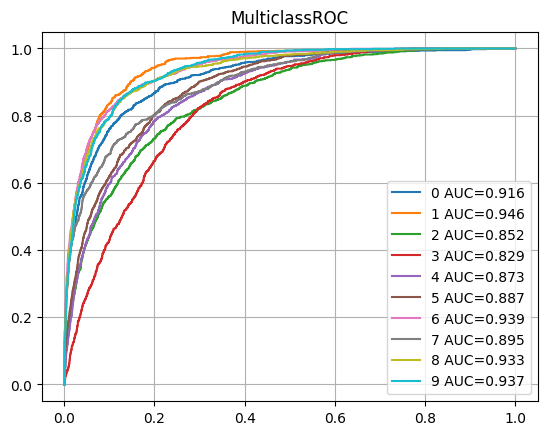

Momentum Gradient Sampling


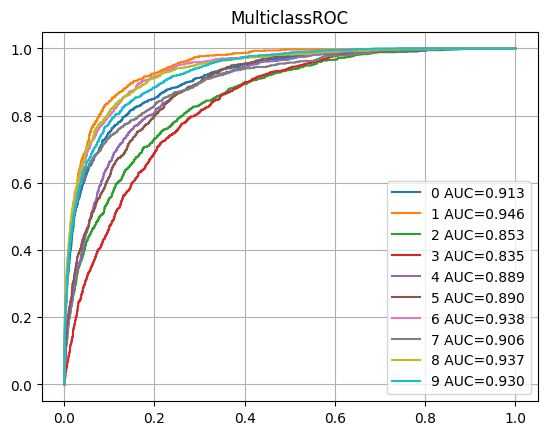

Sgd Gradient Sampling


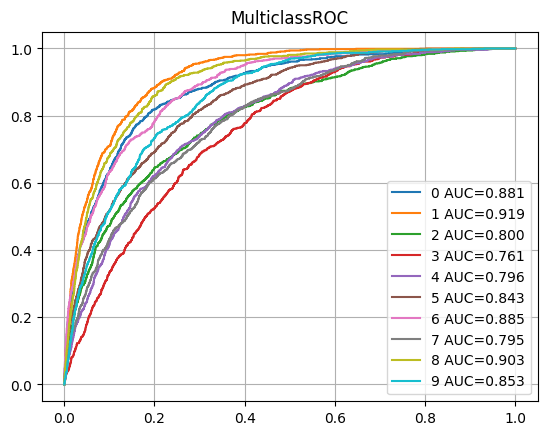

Nag


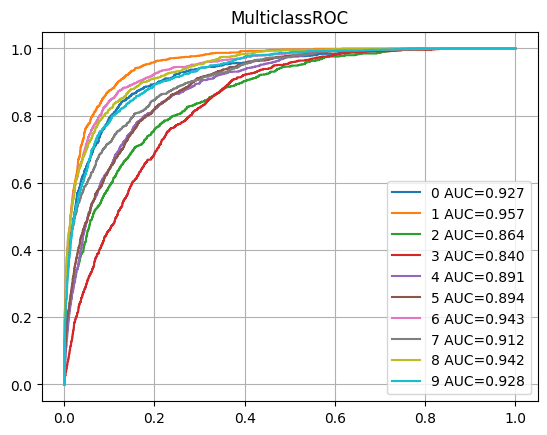

Momentum


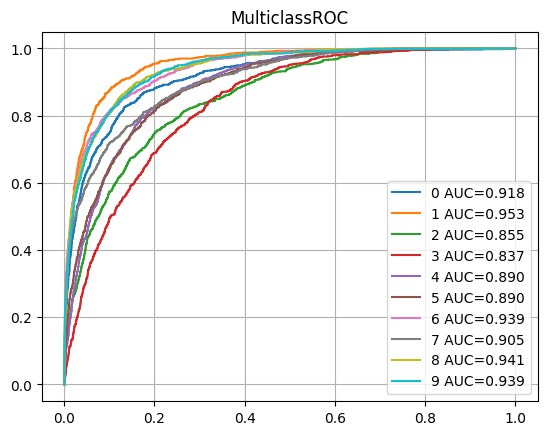

Sgd


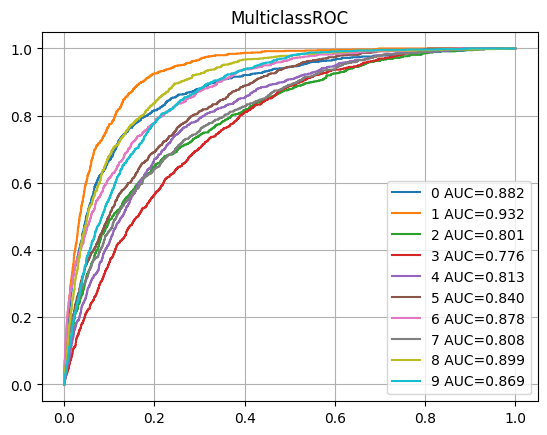

In [11]:
print("Nag Gradient Sampling")
metric = MulticlassROC(num_classes=10, thresholds=None)
fpr, tpr, thresholds = metric(gs_nag_pred, gs_nag_true)
fig_, ax_ = metric.plot(score=True)
plt.show()

print("Momentum Gradient Sampling")
metric = MulticlassROC(num_classes=10, thresholds=None)
fpr, tpr, thresholds = metric(gs_momentum_pred, gs_momentum_true)
fig_, ax_ = metric.plot(score=True)
plt.show()

print("Sgd Gradient Sampling")
metric = MulticlassROC(num_classes=10, thresholds=None)
fpr, tpr, thresholds = metric(gs_sgd_pred, gs_sgd_true)
fig_, ax_ = metric.plot(score=True)
plt.show()

print("Nag")
metric = MulticlassROC(num_classes=10, thresholds=None)
fpr, tpr, thresholds = metric(nag_pred, nag_true)
fig_, ax_ = metric.plot(score=True)
plt.show()

print("Momentum")
metric = MulticlassROC(num_classes=10, thresholds=None)
fpr, tpr, thresholds = metric(momentum_pred, momentum_true)
fig_, ax_ = metric.plot(score=True)
plt.show()

print("Sgd")
metric = MulticlassROC(num_classes=10, thresholds=None)
fpr, tpr, thresholds = metric(sgd_pred, sgd_true)
fig_, ax_ = metric.plot(score=True)
plt.show()

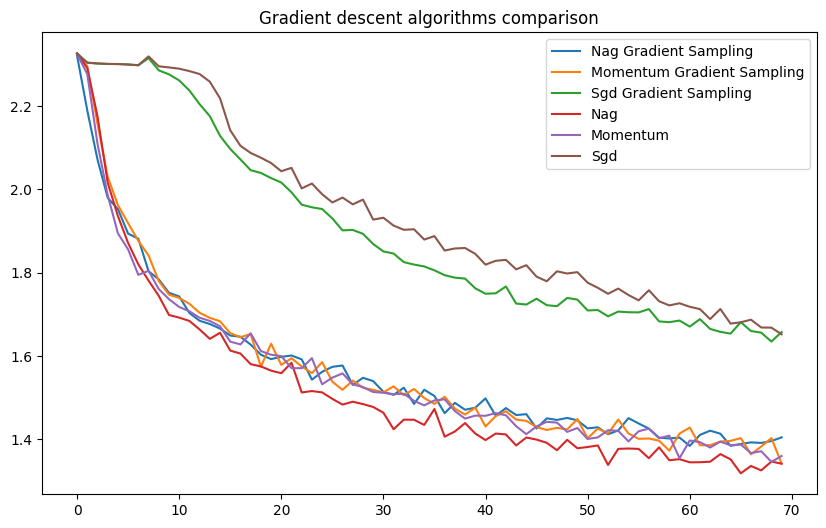

In [12]:
fig = plt.figure(figsize=(10, 6))

plt.plot(gs_nag_losses, label='Nag Gradient Sampling')
plt.plot(gs_momentum_losses, label='Momentum Gradient Sampling')
plt.plot(gs_sgd_losses, label='Sgd Gradient Sampling')
plt.plot(nag_losses, label='Nag')
plt.plot(momentum_losses, label='Momentum')
plt.plot(sgd_losses, label='Sgd')

plt.title('Gradient descent algorithms comparison')
plt.legend()
plt.show()

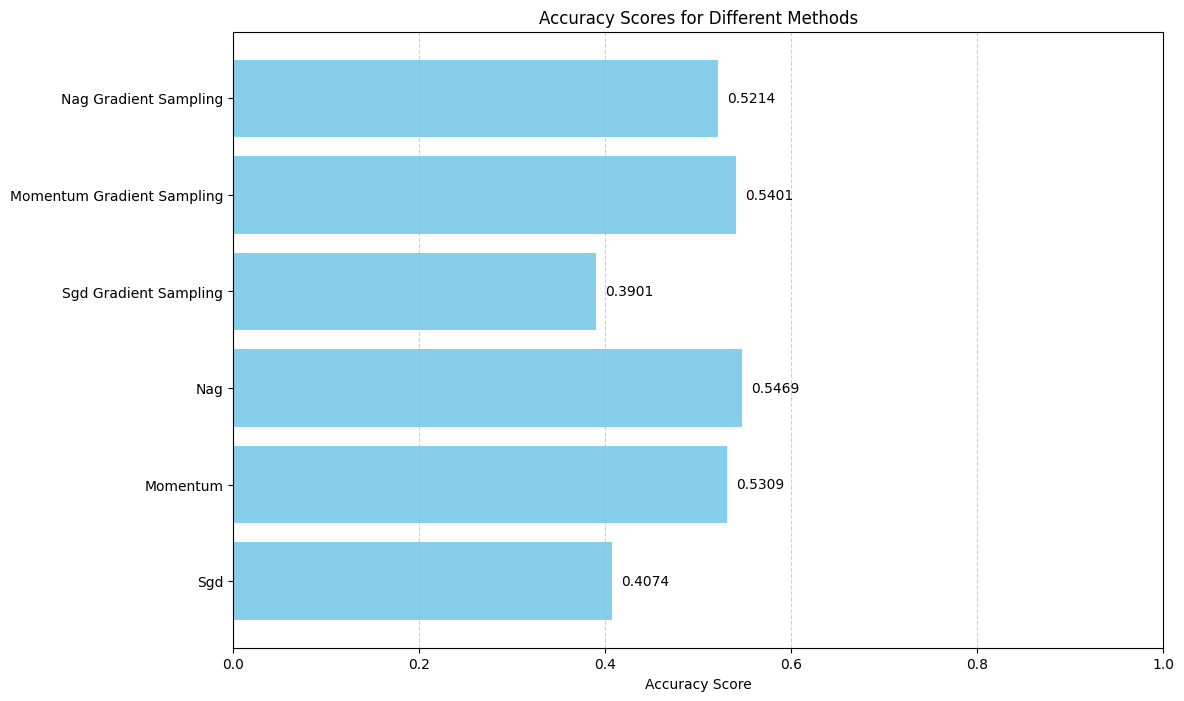

In [13]:
# List of accuracy scores
accuracy_scores = [gs_nag_score, gs_momentum_score, gs_sgd_score, nag_score, momentum_score, sgd_score]

# Corresponding labels or methods
methods = ['Nag Gradient Sampling', 'Momentum Gradient Sampling', 'Sgd Gradient Sampling', 'Nag', 'Momentum', 'Sgd']

# Create a bar chart
plt.figure(figsize=(12, 8))
plt.barh(methods, accuracy_scores, color='skyblue')
plt.xlabel('Accuracy Score')
plt.title('Accuracy Scores for Different Methods')
plt.xlim(0, 1)  # Set the x-axis limits from 0 to 1 for accuracy scores
plt.gca().invert_yaxis()  # Invert the y-axis to display the highest accuracy at the top
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Display the values on the bars
for i, score in enumerate(accuracy_scores):
    plt.text(score + 0.01, i, f'{score:.4f}', va='center')

plt.show()

In [14]:
import csv

# Example X and Y arrays
X = [1, 2, 3, 4, 5]
Y = [10, 20, 30, 40, 50]

# Writing X and Y arrays to a CSV file
def create_csv_two(X, Y, name):
    with open(name + '.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['X', 'Y'])  # Writing header
        for i in range(len(X)):
            writer.writerow([X[i], Y[i]])

def create_csv_one(data, name):
    with open(name + '.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Data'])  # Writing header
        for value in data:
            writer.writerow([value])

create_csv_one(gs_nag_losses,'gs_nag_losses')
create_csv_one(gs_momentum_losses,'gs_momentum_losses')
create_csv_one(gs_sgd_losses,'gs_sgd_losses')

create_csv_one(nag_losses,'nag_losses')
create_csv_one(momentum_losses,'momentum_losses')
create_csv_one(sgd_losses,'sgd_losses')